In [1]:
import yfinance as yf

data = yf.download(tickers = "GC=F", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [2]:
data = data.reset_index('Date', inplace=False)

In [3]:
df = data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [5]:
df1=df.reset_index()['Close']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [11]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 9s 376ms/step - loss: 0.1194 - val_loss: 0.0581
Epoch 2/100
14/14 [==============================] - 3s 227ms/step - loss: 0.0210 - val_loss: 0.0090
Epoch 3/100
14/14 [==============================] - 4s 268ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 4/100
14/14 [==============================] - 3s 240ms/step - loss: 0.0074 - val_loss: 0.0103
Epoch 5/100
14/14 [==============================] - 4s 304ms/step - loss: 0.0060 - val_loss: 0.0127
Epoch 6/100
14/14 [==============================] - 3s 247ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 7/100
14/14 [==============================] - 3s 240ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 8/100
14/14 [==============================] - 5s 363ms/step - loss: 0.0034 - val_loss: 0.0068
Epoch 9/100
14/14 [==============================] - 2s 125ms/step - loss: 0.0030 - val_loss: 0.0085
Epoch 10/100
14/14 [==============================] - 2s 124ms/step - loss: 0.0030 - val_lo

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 19ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [15]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 27.747809737715958
Testing RMSE: 21.594491342817697


In [17]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 23.0819732666016
Testing MAE: 17.58405678959216


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

In [19]:
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 27.747809737715958
Testing MAPE: 21.594491342817697


In [20]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.8656461  0.87398601 0.86016221 0.85959098 0.85307898 0.86061922
 0.85867709 0.84553874 0.78453106 0.78830111 0.79458467 0.80109681
 0.78830111 0.78441684 0.77196394 0.77436309 0.75174222 0.7606535
 0.75882559 0.75037132 0.74922885 0.73323433 0.72272371 0.73209187
 0.74568724 0.75574085 0.75094255 0.7671655  0.76739408 0.72855025
 0.72717921 0.74614425 0.78350281 0.84028328 0.83399972 0.85730605
 0.84862334 0.90666063 0.9173997  0.87033018 0.88038393 0.9340798
 0.92071287 0.88678171 0.90963102 0.90243343 0.91865652 0.90574661
 0.92276937 0.96652571 0.96504059 0.9547584  0.92871013 0.94664692
 0.95361593 0.98834691 0.9436764  0.93453668 0.9496173  0.93567914
 0.94984574 0.91774249 0.92871013 0.93430824 0.92482572 0.92962416
 0.9298526  0.92219814 0.95750034 0.97383751 0.99600137 0.96104196
 0.97120993 0.98252022 0.97600823 0.95795722 0.95772878 0.96172741
 0.92791046 0.9191134  0.89146579 0.91682846 0.91237296 0.90963102
 0.89866338 0.87615673 0.87729919 0.89317949 0.89992

In [21]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 21.594491342817697
Validation RMSE: 27.747809737715958
Testing MAE: 17.58405678959216
Validation MAE: 23.0819732666016
Testing MAPE: 0.009898228311790436
Validation MAPE: 0.011564647815646123


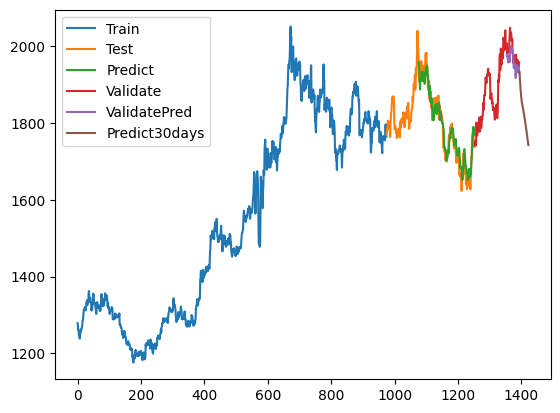

In [22]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [23]:
scaler.inverse_transform(lst_output)

array([[1933.62906458],
       [1933.57814476],
       [1915.52858094],
       [1906.6162035 ],
       [1889.40326905],
       [1881.61926651],
       [1869.01582806],
       [1863.47704532],
       [1854.96926133],
       [1851.07947737],
       [1845.51309567],
       [1841.68289207],
       [1836.90519372],
       [1832.75037626],
       [1828.00768528],
       [1823.29102811],
       [1817.85064166],
       [1812.42011572],
       [1806.35121381],
       [1801.37860106],
       [1794.69761785],
       [1790.59648532],
       [1783.08774198],
       [1779.87718462],
       [1771.4434848 ],
       [1766.58361563],
       [1758.18048857],
       [1753.75124666],
       [1746.53638791],
       [1742.5589029 ]])